# The steps for reproducing the issue in fenicstools Interpolation between different meshes
## Overview
The issue happens with FEniCS 2019.1.0 and fenicstools library when trying to interpolate between non-matching meshes of FEniCS functions. Unstable results are observed when trying to interpolate a solution function solved on a coarse mesh function space to a fine mesh function space. 

In [20]:
import meshio
import os
import numpy as np
import matplotlib.pyplot as plt

from dolfin import *
from fenics import *
from fenicstools.Interpolation import interpolate_nonmatching_mesh
from configparser import ConfigParser
try:
    from dolfin import XDMFFile, Mesh, MeshValueCollection
    from dolfin.cpp.mesh import MeshFunctionSizet
except ImportError:
    print("Could not import dolfin. Continuing without Dolfin support.")

In [21]:
# utility functions
def msh2xdmf(mesh_name, dim=2, directory="."):
    """
    Function converting a MSH mesh into XDMF files.
    The XDMF files are:
        - "domain.xdmf": the domain;
        - "boundaries.xdmf": the boundaries physical groups from GMSH;
    """

    # Get the mesh name has prefix
    prefix = mesh_name.split('.')[0]
    # Read the input mesh
    msh = meshio.read("{}/{}".format(directory, mesh_name))
    # Generate the domain XDMF file
    export_domain(msh, dim, directory, prefix)
    # Generate the boundaries XDMF file
    export_boundaries(msh, dim, directory, prefix)
    # Export association table
    export_association_table(msh, prefix, directory)


def export_domain(msh, dim, directory, prefix):
    """
    Export the domain XDMF file as well as the subdomains values.
    """
    # Set cell type
    if dim == 2:
        cell_type = "triangle"
    elif dim == 3:
        cell_type = "tetra"
    # Generate the cell block for the domain cells
    for i in msh.cells:
        if i.type == cell_type:
            data_array = i.data 
    # data_array = [arr for (t, arr) in msh.cells if t == cell_type]
    
    if len(data_array) == 0:
        print("WARNING: No domain physical group found.")
        return
    else:
        # data = np.concatenate(data_array) # Use this expression if more than 1 domain
        data = data_array
    cells = [
        meshio.CellBlock(
            cell_type=cell_type,
            data=data,
        )
    ]
    # Generate the domain cells data (for the subdomains)
    try:
        cell_data = {
            "subdomains": [
                np.concatenate(
                    [
                        msh.cell_data["gmsh:physical"][i]
                        for i, cellBlock in enumerate(msh.cells)
                        if cellBlock.type == cell_type
                    ]
                )
            ]
        }
    except KeyError:
        raise ValueError(
            """
            No physical group found for the domain.
            Define the domain physical group.
                - if dim=2, the domain is a surface
                - if dim=3, the domain is a volume
            """
        )

    # Generate a meshio Mesh for the domain
    domain = meshio.Mesh(
        points=msh.points[:, :dim],
        cells=cells,
        cell_data=cell_data,
    )
    # Export the XDMF mesh of the domain
    meshio.write(
        "{}/{}_{}".format(directory, prefix, "domain.xdmf"),
        domain,
        file_format="xdmf"
    )


def export_boundaries(msh, dim, directory, prefix):
    """
    Export the boundaries XDMF file.
    """
    # Set the cell type
    if dim == 2:
        cell_type = "line"
    elif dim == 3:
        cell_type = "triangle"
    # Generate the cell block for the boundaries cells
    # data_array = [arr for (t, arr) in msh.cells if t == cell_type]
    data_array = []
    for i in msh.cells:
        if i.type == cell_type:
            data_array.append(i.data) 
    if len(data_array) == 0:
        print("WARNING: No boundary physical group found.")
        return
    else:
        data = np.concatenate(data_array)
        # data = data_array
    boundaries_cells = [
        meshio.CellBlock(
            cell_type=cell_type,
            data=data,
        )
    ]
    # Generate the boundaries cells data
    cell_data = {
        "boundaries": [
            np.concatenate(
                [
                    msh.cell_data["gmsh:physical"][i]
                    for i, cellBlock in enumerate(msh.cells)
                    if cellBlock.type == cell_type
                ]
            )
        ]
    }
    # Generate the meshio Mesh for the boundaries physical groups
    boundaries = meshio.Mesh(
        points=msh.points[:, :dim],
        cells=boundaries_cells,
        cell_data=cell_data,
    )
    # Export the XDMF mesh of the lines boundaries
    meshio.write(
        "{}/{}_{}".format(directory, prefix, "boundaries.xdmf"),
        boundaries,
        file_format="xdmf"
    )


def export_association_table(msh, prefix='mesh', directory='.', verbose=True):
    """
    Display the association between the physical group label and the mesh
    value.
    """
    # Create association table
    association_table = {}

    # Display the correspondance
    formatter = "|{:^20}|{:^20}|"
    topbot = "+{:-^41}+".format("")
    separator = "+{:-^20}+{:-^20}+".format("", "")

    # Display
    if verbose:
        print('\n' + topbot)
        print(formatter.format("GMSH label", "MeshFunction value"))
        print(separator)

    for label, arrays in msh.cell_sets.items():
        # Get the index of the array in arrays
        for i, array in enumerate(arrays):
            if array.size != 0:
                index = i
        # Added check to make sure that the association table
        # doesn't try to import irrelevant information.
        if label != "gmsh:bounding_entities":
            value = msh.cell_data["gmsh:physical"][index][0]
            # Store the association table in a dictionnary
            association_table[label] = value
            # Display the association
            if verbose:
                print(formatter.format(label, value))
    if verbose:
        print(topbot)
    # Export the association table
    file_content = ConfigParser()
    file_content["ASSOCIATION TABLE"] = association_table
    file_name = "{}/{}_{}".format(directory, prefix, "association_table.ini")
    with open(file_name, 'w') as f:
        file_content.write(f)

def import_mesh(
        prefix="mesh",
        subdomains=False,
        dim=2,
        directory=".",
):
    """Function importing a dolfin mesh.

    Arguments:
        prefix (str, optional): mesh files prefix (eg. my_mesh.msh,
            my_mesh_domain.xdmf, my_mesh_bondaries.xdmf). Defaults to "mesh".
        subdomains (bool, optional): True if there are subdomains. Defaults to
            False.
        dim (int, optional): dimension of the domain. Defaults to 2.
        directory (str, optional): directory of the mesh files. Defaults to ".".

    Output:
        - dolfin Mesh object containing the domain;
        - dolfin MeshFunction object containing the physical lines (dim=2) or
            surfaces (dim=3) defined in the msh file and the sub-domains;
        - association table
    """
    # Set the file name
    domain = "{}_domain.xdmf".format(prefix)
    boundaries = "{}_boundaries.xdmf".format(prefix)

    # create 2 xdmf files if not converted before
    if not os.path.exists("{}/{}".format(directory, domain)) or \
       not os.path.exists("{}/{}".format(directory, boundaries)):
        msh2xdmf("{}.msh".format(prefix), dim=dim, directory=directory)

    # Import the converted domain
    mesh = Mesh()
    with XDMFFile("{}/{}".format(directory, domain)) as infile:
        infile.read(mesh)
    # Import the boundaries
    boundaries_mvc = MeshValueCollection("size_t", mesh, dim=dim)
    with XDMFFile("{}/{}".format(directory, boundaries)) as infile:
        infile.read(boundaries_mvc, 'boundaries')
    boundaries_mf = MeshFunctionSizet(mesh, boundaries_mvc)
    # Import the subdomains
    if subdomains:
        subdomains_mvc = MeshValueCollection("size_t", mesh, dim=dim)
        with XDMFFile("{}/{}".format(directory, domain)) as infile:
            infile.read(subdomains_mvc, 'subdomains')
        subdomains_mf = MeshFunctionSizet(mesh, subdomains_mvc)
    # Import the association table
    association_table_name = "{}/{}_{}".format(
        directory, prefix, "association_table.ini")
    file_content = ConfigParser()
    file_content.read(association_table_name)
    association_table = dict(file_content["ASSOCIATION TABLE"])
    # Convert the value from string to int
    for key, value in association_table.items():
        association_table[key] = int(value)
    # Return the Mesh and the MeshFunction objects
    if not subdomains:
        return mesh, boundaries_mf, association_table
    else:
        return mesh, boundaries_mf, subdomains_mf, association_table

In [22]:
# mesh name and t
mesh_name = 'circle_1'
t = 400
type = 'circle'

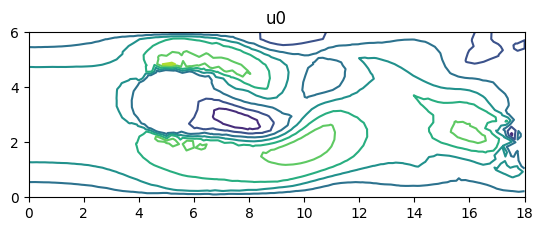

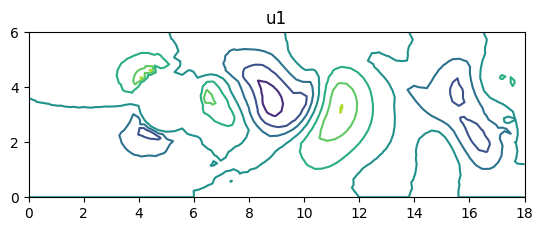

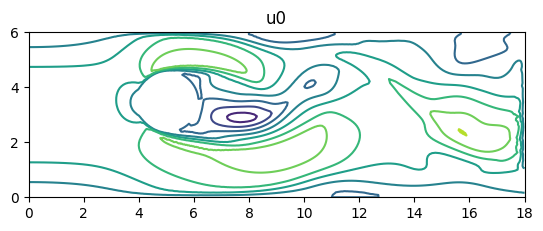

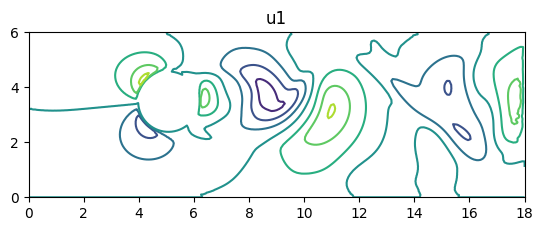

In [23]:
# Read in mesh and solution
mesh_l, mf_boundaries_l, association_table_l = import_mesh(prefix=mesh_name, directory='mesh/{}/las'.format(type))
mesh_h, mf_boundaries_h, association_table_h = import_mesh(prefix=mesh_name, directory='mesh/{}/has'.format(type))

gdim = mesh_l.geometry().dim()
tdim = mesh_l.topology().dim()

V = FunctionSpace(mesh_h, 'CG', 2)
Q = FunctionSpace(mesh_h, 'CG', 1)
u0 = Function(V)
u1 = Function(V)
p = Function(Q)

Vl = FunctionSpace(mesh_l, 'CG', 2)
Ql = FunctionSpace(mesh_l, 'CG', 1)
u0_l = Function(Vl)
u1_l = Function(Vl)
p_l = Function(Ql)

velocity_x = TimeSeries('solution/{}_has/data/1/Timeseries/u0_from_tstep_0'.format(mesh_name))
velocity_y = TimeSeries('solution/{}_has/data/1/Timeseries/u1_from_tstep_0'.format(mesh_name))
pressure = TimeSeries('solution/{}_has/data/1/Timeseries/p_from_tstep_0'.format(mesh_name))

velocity_xl = TimeSeries('solution/{}_las/data/1/Timeseries/u0_from_tstep_0'.format(mesh_name))
velocity_yl = TimeSeries('solution/{}_las/data/1/Timeseries/u1_from_tstep_0'.format(mesh_name))
pressure_l = TimeSeries('solution/{}_las/data/1/Timeseries/p_from_tstep_0'.format(mesh_name))

velocity_x.retrieve(u0.vector(), t)
velocity_y.retrieve(u1.vector(), t)
pressure.retrieve(p.vector(), t)

velocity_xl.retrieve(u0_l.vector(), t)
velocity_yl.retrieve(u1_l.vector(), t)
pressure_l.retrieve(p_l.vector(), t)
plt.figure()
plot(u0_l, title='u0', mode='contour')

plt.figure()
plot(u1_l, title='u1', mode='contour')

# plot velocity contour of original solution
plt.figure()
plot(u0, title='u0', mode='contour')
plt.figure()
plot(u1, title='u1', mode='contour')
plt.show()

Notice that the original solution functions seem smooth and fine. 

Building point search tree to accelerate distance queries.
Computed bounding box tree with 5549 nodes for 2775 points.


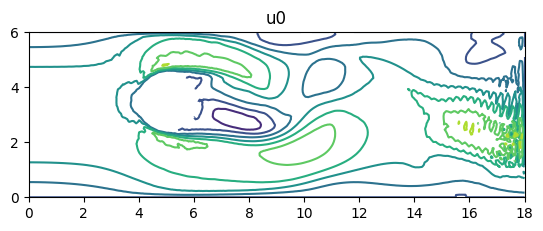

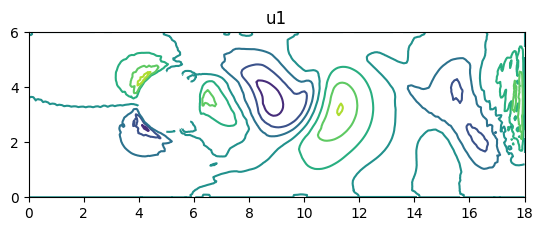

Building point search tree to accelerate distance queries.
Computed bounding box tree with 48689 nodes for 24345 points.


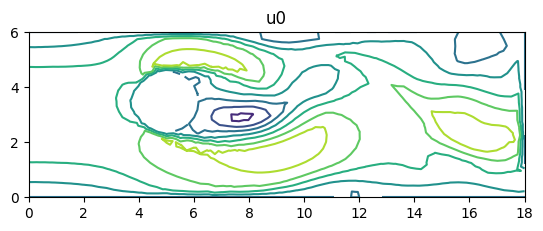

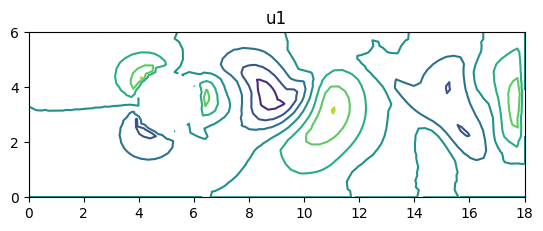

In [24]:
# plot velocity contour of interpolated solution
u0_l_ = interpolate_nonmatching_mesh(u0_l, V)
u1_l_ = interpolate_nonmatching_mesh(u1_l, V)
p_l_ = interpolate_nonmatching_mesh(p_l, Q)

plt.figure()
plot(u0_l_, title='u0', mode='contour')
plt.show()
plt.figure()
plot(u1_l_, title='u1', mode='contour')
plt.show()

u0_ = interpolate_nonmatching_mesh(u0, Vl)
u1_ = interpolate_nonmatching_mesh(u1, Vl)
p_ = interpolate_nonmatching_mesh(p, Ql)

plt.figure()
plot(u0_, title='u0', mode='contour')
plt.show()
plt.figure()
plot(u1_, title='u1', mode='contour')
plt.show()

Notice that, when performing shape function interpolation from a low resolution mesh to a high resolution mesh, the interpolation results are not smooth at the far end of the domain, and exhibit a sawtooth pattern. However the issue is not observed when interpolating from a high resolution mesh to a low resolution mesh.